In [17]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [18]:
data = load_diabetes(as_frame=True)
X = data['frame']
y = data['target']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [20]:
regr1 = DecisionTreeRegressor(max_depth=10, random_state=42)
regr1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [21]:
regr2 = RandomForestRegressor(max_depth=10,n_estimators=10, random_state=42)
regr2.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [22]:
y_pred1 = regr1.predict(X_test)
y_pred2 = regr2.predict(X_test)

print(f'Качество предсказания по MSE для решающего дерева {round(mean_squared_error(y_test, y_pred1),2)}')
print(f'Качество предсказания по MSE для случайного леса  {round(mean_squared_error(y_test, y_pred2),2)}')

Качество предсказания по MSE для решающего дерева 4.09
Качество предсказания по MSE для случайного леса  1.84


# **3. Ансамблирование: блендинг и стекинг**

## **Стекинг** (stacking) — алгоритм построения ансамбля, в котором параллельно и независимо друг от друга обучаются несколько базовых моделей (необязательно одной природы), а их предсказания используются для обучения **метамодели** (финальная модель) как факторы.

Предсказания базовых алгоритмов называются **метапризнаками**. 

# БЛЕНДИНГ

Простейшая реализация стекинга заключается в **блендинге** (blending). 

Схематично блендинг можно представить следующим образом:

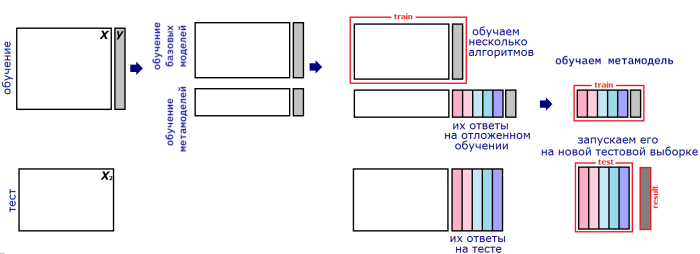

Суть блендинга состоит в следующем: предположим у нас есть обучающая выборка $X$, которую мы делим пополам. Первая часть используется для обучения базовых моделей, а на второй базовые модели делают предсказания – **метапризнаки**, на которых уже и обучается в дальнейшем метамодель. 

## **Недостатки блендинга** видны невооруженным глазом: ни базовые модели, ни метамодель не обучаются на полных данных. 

#  СТЕКИНГ

Для решения этой проблемы используется усовершенствованная модель блендинга, которая имеет полноценное название — **стекинг**. Идея борьбы с недостатком блендинга — использование **кросс-валидации**.

### Рассмотрим как обучается классический стекинг. Пусть у нас есть таблица с примерами X и ответами на них y. Количество признаков — $m$, количество наблюдений — $n$, количество моделей в стекинге — $K$.

1. Обучающая выборка разбивается на $L$ равных частей, называемых **фолдами**. Например, для трёх фолдов ($L$ = 3) схематично это будет выглядеть следующим образом:

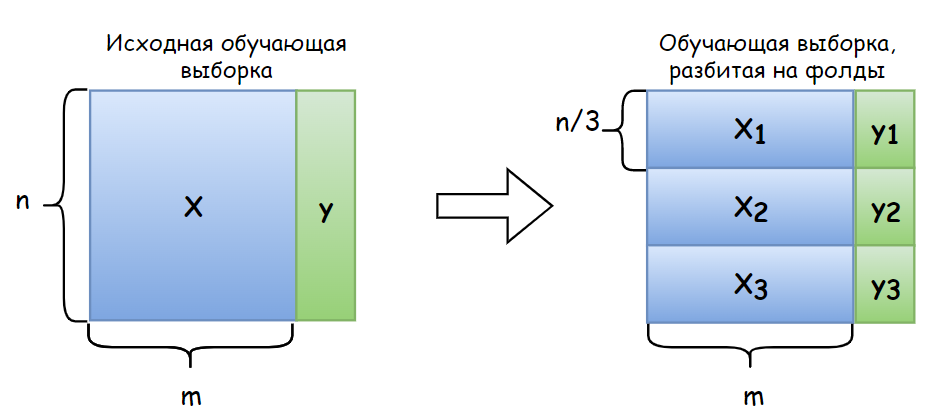



2. Затем для каждой базовой модели эти фолды перебираются следующим образом: на каждом шаге фиксируются $L$ - 1 фолдов для обучения базовых моделей и один фолд для предсказания (в случае бинарной классификации каждая модель предсказывает вероятность принадлежности к классу 1, в случае мультиклассовой классификации — к каждому классу). В результате будет сформировано $L$ предсказаний, из которых формируется метапризнак $M_j$, где $j$ — номер модели:

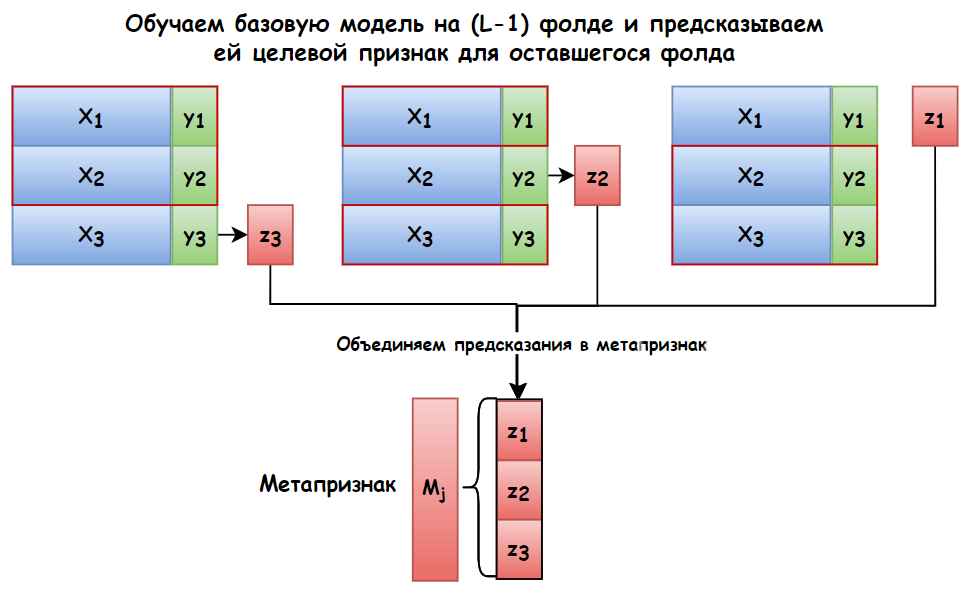

Такой подход к формированию метапризнаков позволяет избежать переобучения. Действительно, можно рассматривать $L$ - 1-фолд как обучающую выборку, а оставшийся — как тестовую. Таким образом, мы обучаемся на тренировочной выборке, но предсказания делаем для той выборки, которую ещё не видели.

3. После того как мы проделаем шаг 2 для всех базовых моделей, мы получим новый набор данных, состоящий из $K$ метапризнаков — предсказаний каждой из моделей. Предсказания моделей будут использоваться в качестве метапризнаков, на которых будет обучена метамодель.

Пусть мы взяли три разных модели, т. е. $K$ = 3. Это будет выглядеть следующим образом:

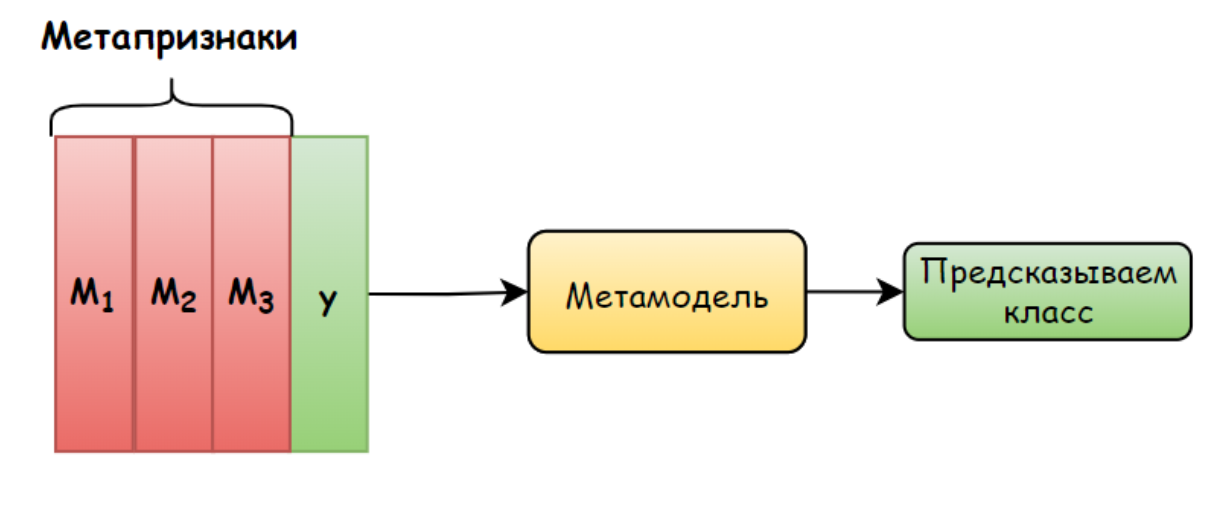

**Примечание.** Кроме метафакторов, метамодель может использовать для своего обучения изначальные признаки из исходного набора данных.

### Давайте посмотрим, как работает алгоритм на конкретной таблице. Пусть у нас есть некоторый набор данных из четырёх признаков, характеризующих клиента (x_0, x_1, x_2 и x_3), и восемь наблюдений. На основе этих признаков необходимо предсказать бинарный целевой признак (y) покупки товара со значениями 1 (купил) и 0 (не купил). Будем использовать стекинг, состоящий из трёх различных моделей.

Разбиваем выборку на четыре фолда, то есть в каждом фолде будет по две строки таблицы (обозначены цветом). Обучаем каждую модель на трёх из этих фолдов и делаем предсказание вероятности покупки для оставшегося.

Из предсказаний будет сформировано три метапризнака (по одному на каждую базовую модель). Это будут предсказанные базовыми классификаторами вероятности покупки (вероятность принадлежности к классу 1).

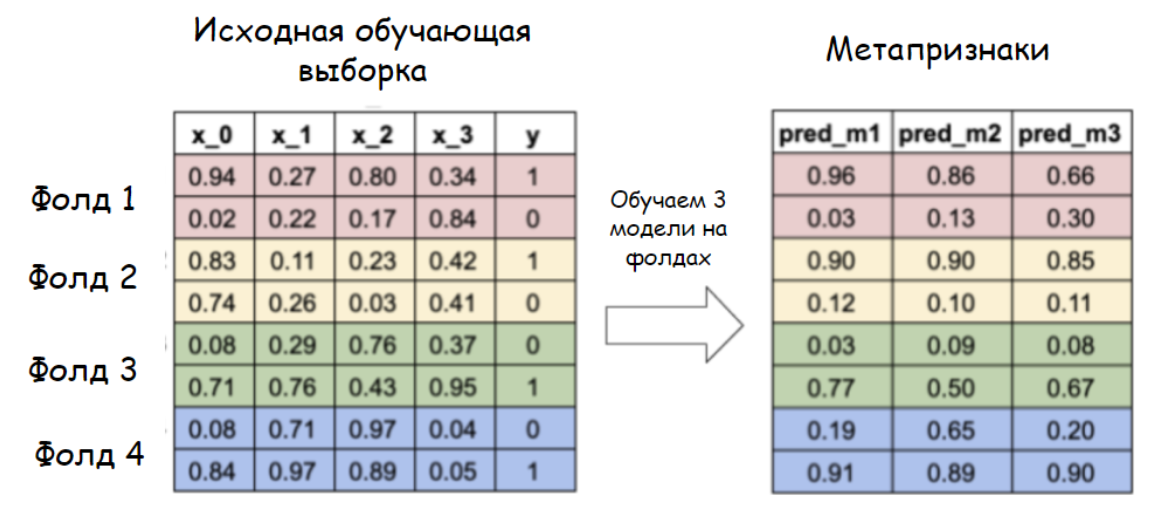

Формируем новый набор данных и отправляем его в метамодель, которая уже и делает финальное предсказание целевого признака покупки:

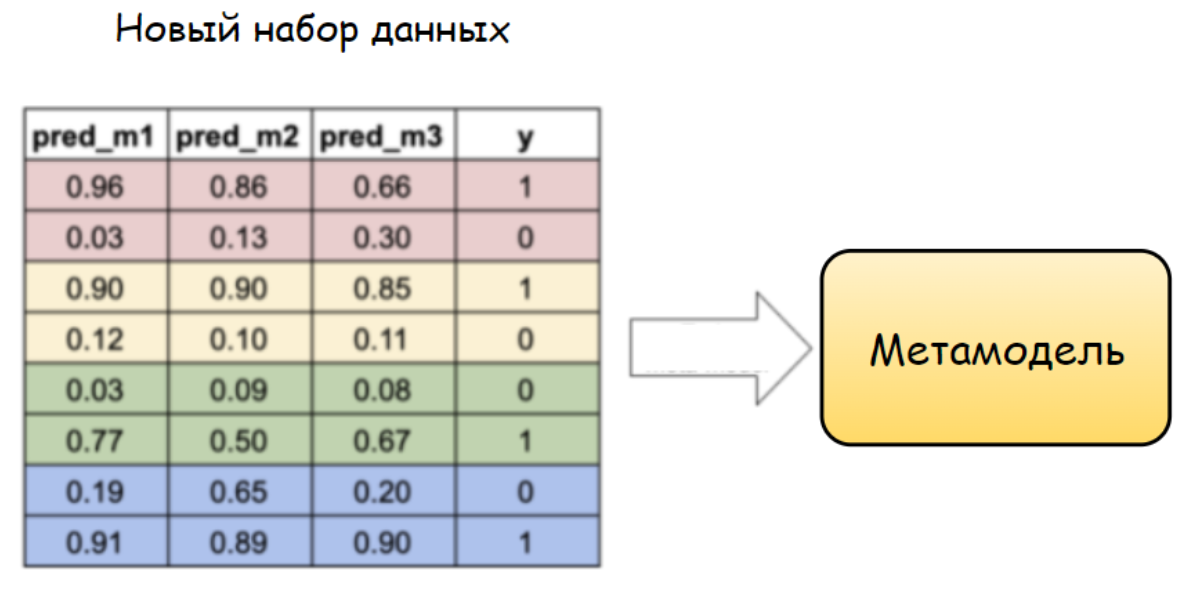

Метамодель будет производить поиск зависимостей в данных и принимать решение уже на основе предсказанных вероятностей покупки, которые были получены на первом этапе. 

В общем случае, когда у нас есть $K$ моделей, общая схема стекинга будет иметь вид:

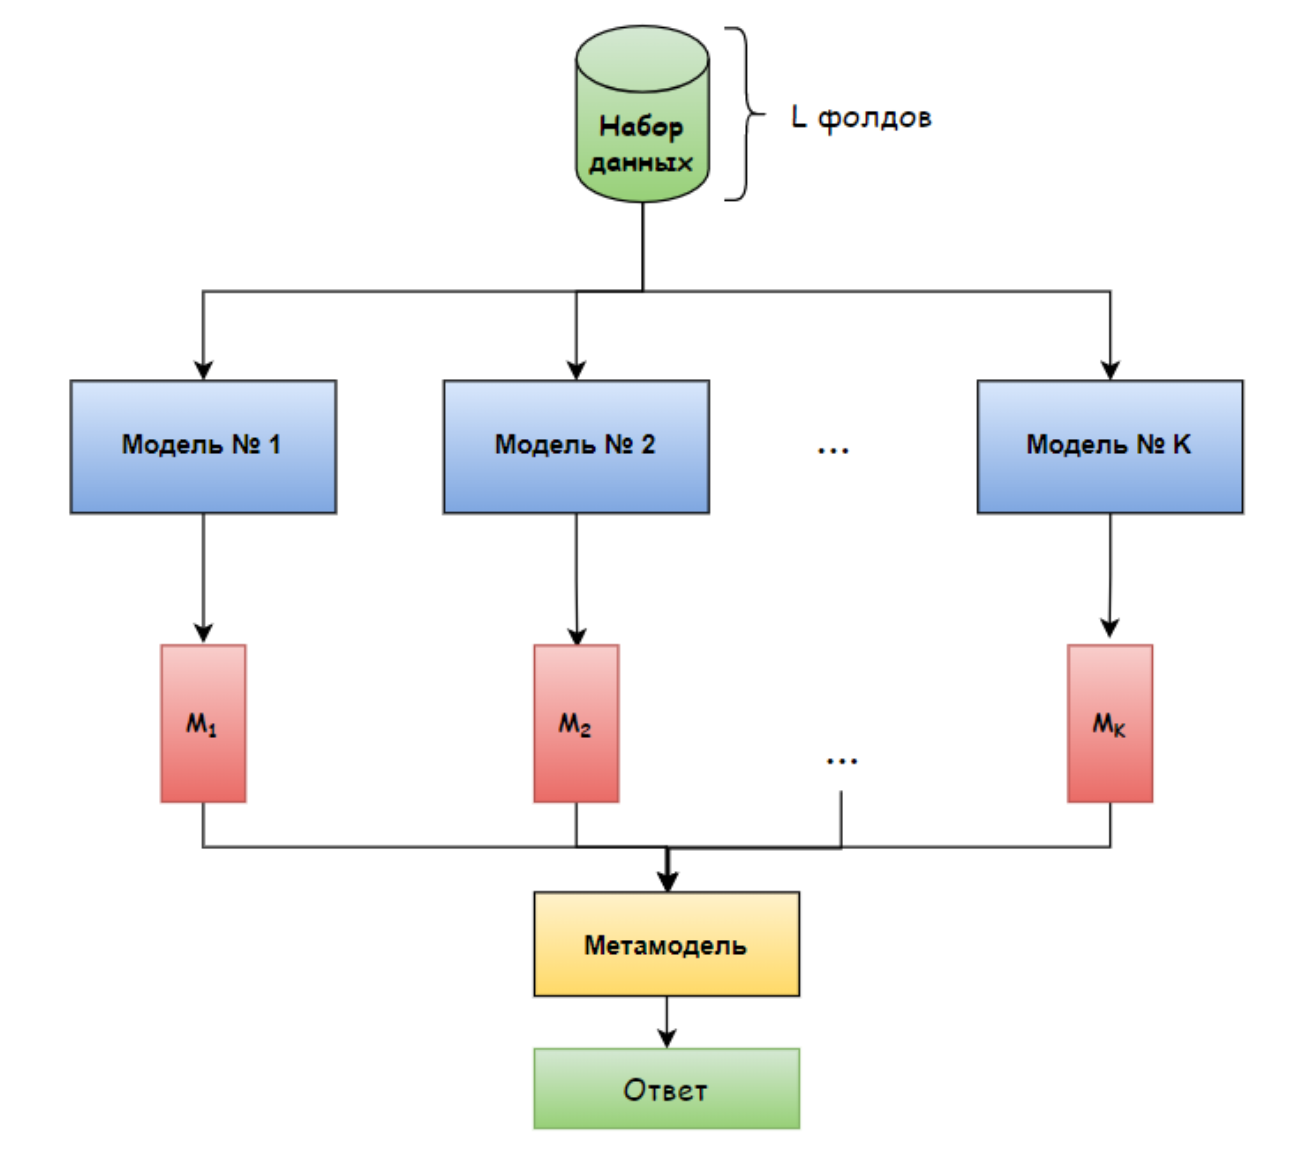

## Важно понимать, стекинг — это чистая эвристика, эффективность которой доказана только практическим применением. Стекинг использует тот же подход, что и нейронные сети: предсказания предыдущего этапа (слоя) используются в качестве признаков для следующего этапа (слоя).

## С точки зрения смещения и разброса, стекинг не имеет прямой математической интерпретации, так как не минимизирует напрямую ни ту, ни другую компоненту ошибки. Удачно работающий стекинг просто уменьшает ошибку, но гарантий уменьшения смещения или разброса нет.

### Есть некоторые **рекомендации, как правильно строить стекинг:**

+ В качестве метамоделей лучше всего применять простые модели: например, для задачи регрессии — линейную регрессию, а для задачи классификации — логистическую регрессию.
+ В качестве базовых моделей лучшего всего использовать модели различной природы.

### Из всех ансамблевых методов стекинг применяется реже всего. Главная причина: так как используется много разных моделей, необходимо подбирать их внешние параметры (коэффициенты регуляризации, глубина деревьев, число деревьев, темп обучения и т. д.) в совокупности, а подбор огромного количества параметров очень затратен по времени (мы убедились в этом в модуле по подбору внешних параметров моделей).

### Вторая причина — в отличие от бэггинга и бустинга, для стекинга нет каких-то готовых решений, таких как случайный лес и градиентный бустинг над деревьями. Базовые модели нужно подбирать самому, а какие из них подойдут лучше всего — открытый вопрос.

Но, несмотря на эти недостатки, при грамотном подходе опытные специалисты выигрывают соревнования на Kaggle благодаря стекингу. Хотя зачастую таких участников называют «читерами» (от англ. cheat — «жульничать, обманывать»), ведь часто они собирают чуть ли не все возможные ML-модели в стекинг, запускают на мощном сервере подбор внешних параметров и комбинации из этих моделей в стекинге получают заветные 1.5 % прироста качества модели. На Kaggle даже существует фраза — «настекали».

В реальных условиях такой прирост значит мало, поэтому мы не будем концентрироваться на стекинге в нашем курсе, но пример разберём.

## Задание 3.1

Какие утверждения о блендинге верны?

+ Блендинг — упрощённая модель стекинга.
+ Метамодель обучается только на метаданных.

## Задание 3.2

Вы используете стекинг из 10 моделей машинного обучения и данные, разбитые на 5 фолдов, для решения задачи бинарной классификации. Все базовые модели обучаются на всех признаках исходного датасета.

Какое утверждение верно для стекинга с одним уровнем ($K$ базовых моделей и одна метамодель)?

+ После первой стадии у вас останется только 10 признаков

После прохождения первого этапа у вас получится набор данных, состоящий из метапризнаков, их число равно количеству базовых моделей в ансамбле, то есть 10.

## Задание 3.3

Какие из следующих утверждений верны для стекинга?

+ Метамодель обучается на предсказаниях разных моделей машинного обучения.
+ Модели на первой стадии обучаются на признаках исходного набора данных.

## Задание 3.4

Зачем необходимо разделять выборку на фолды при обучении базовых моделей?

+ Обучая на одних фолдах и формируя предсказания на других, мы уменьшаем шанс переобучения



# СТЕКИНГ В SKLEARN


Стекинг для задачи регрессии имеет реализацию в библиотеке scikit-learn в классе StackingRegressor, для задачи классификации — в классе StackingClassifier. На вход подаётся список базовых моделей (атрибут estimators) и метамодель (атрибут final_estimator).

**Примечание.** Стоит понимать, что для задачи регрессии все базовые модели должны быть регрессорами, а для задачи классификации — классификаторами.  

Попробуем на практике применить стекинг, используя реализацию из библиотеки sklearn. В качестве входных данных будем использовать данные про диабет, использованные ранее. Обратимся снова к коду и обучим модель на данных.

Как и все ансамбли, модель стекинга находится в модуле ensemble.

In [23]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

Основные параметры StackingRegressor:

+ estimators — список из кортежей базовых моделей в виде (str, model). Первым элементом в каждом кортеже идет строка с именем модели, вторым — собственно сама модель.
+ final_estimator — метамодель.
+ cv — количество фолдов, на которые делится выборка. По умолчанию используется пять фолдов.
 
Будем строить стекинг на следующих моделях:

+ 'dt' — дерево решений;
+ 'lr' — ридж-регрессия, линейная модель регрессии с L2-регуляризацией;
+ случайный лес с количеством деревьев, равным 10, в качестве метамодели.

### **Примечание.** В данном случае мы рассматриваем **RidgeCV**, которая представляет собой ридж-регрессию со встроенной кросс-валидацией по методу **Leave-One-Out Cross-Validation**.

Создадим список кортежей в формате ("наименование модели", модель) из этих моделей, и назовем его estimators:

In [24]:
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]

Теперь, когда список из базовых моделей готов, создадим объект класса StackingRegressor. Первым аргументом передаём список из базовых моделей. Будем использовать в качестве метамодели модель случайного леса. Для этого передаём её в параметр final_estimator. Остальные параметры оставим по умолчанию.

Обучаем модель с помощью метода fit(), делаем предсказание классов с помощью метода predict(), а затем считаем метрики:

In [25]:
#Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)
#Обучаем модель
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('dt', DecisionTreeRegressor(random_state=42))],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=42))

In [26]:
y_pred_stack = reg.predict(X_test)
print(f'Качество предсказания по MSE для стекинга {round(mean_squared_error(y_test, y_pred_stack),2)}')

Качество предсказания по MSE для стекинга 0.82


Посмотреть на метапризнаки можно с помощью метода **transform()**. Для этого в метод нужно передать матрицу наблюдений X. В результате вызова метода для всех объектов каждая из трёх моделей сделает предсказание вероятностей и вернёт матрицу из двух столбцов. Оформим её в виде DataFrame:

In [16]:
meta_data = reg.transform(X_train)
#Создаем DataFrame
meta_df = pd.DataFrame(
    meta_data, #содержимое таблицы
    columns=['meta_feature1', 'meta_feature2',] #название столбцов
)
meta_df.head()

,meta_feature1,meta_feature2
0,154.000000,154.0
1,192.000001,192.0
2,116.000002,116.0
3,81.000007,81.0
4,122.000005,122.0


↑ Наша таблица метапризнаков, на которой происходит обучение метамодели случайного леса. 

**Примечание.** При желании к метапризнакам можно добавить столбцы из изначального набора данных и попробовать обучить модель на этом наборе данных.

 ⬇️ Мы рассмотрели основные принципы работы стекинга и его реализацию в sklearn. Попробуйте применить стекинг для решения следующей задачи.

## Задание 3.5

Для выполнения задания используйте набор данных о диабете, который представлен в ноутбуке с примерами.

Постройте стекинг из следующих базовых моделей:

Ридж-регрессия (RidgeCV());
Линейная регрессия.
В качестве метамодели используйте случайный лес с количеством деревьев 100, максимальной глубиной 10, все параметры для базовых моделей стандартные. Для всех алгоритмов параметр random_state=42.

Сделайте предсказание целевой метки для тестового набора данных. Рассчитайте метрику MSE для набора данных и запишите её в качестве ответа с точностью до одного знака после запятой.

In [27]:
from sklearn.linear_model import LinearRegression
estimators = [
    ('rr', RidgeCV()),
    ('lr',  LinearRegression())
]

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
)
#Обучаем модель
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('rr', RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('lr', LinearRegression())],
                  final_estimator=RandomForestRegressor(max_depth=10,
                                                        random_state=42))

In [28]:
y_pred_stack = reg.predict(X_test)
print(f'Качество предсказания по MSE для стекинга {round(mean_squared_error(y_test, y_pred_stack),1)}')

Качество предсказания по MSE для стекинга 0.3
